# Final Project: Wine Recommendations

For the final project I will use the Wine Quality dataset from UC Irvine https://archive.ics.uci.edu/dataset/186/wine+quality

## Project Summary

This project uses K-Means Clustering in order to identify similar wines based on their chemical properties. The goal is to determine similar wines and make recomendations based on the results.
***

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

### Step 1: Load Data

In [2]:
red = pd.read_csv('winequality-red.csv', delimiter = ';')
white = pd.read_csv('winequality-white.csv', delimiter = ';')

For the purpose of this notebook, we don't care about differentiating between red and white wines, so we can concatenate them together to get a larger, singular dataset

In [3]:
red['type'] = 'red'
white['type'] = 'white'
data = pd.concat([red, white], ignore_index = True)

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


### Step 2: Data Preprocessing and Analysis

Quality and type are not useful features in this notebook, so we can remove their respective columns.

In [4]:
data = data.drop(['quality', 'type'], axis = 1)

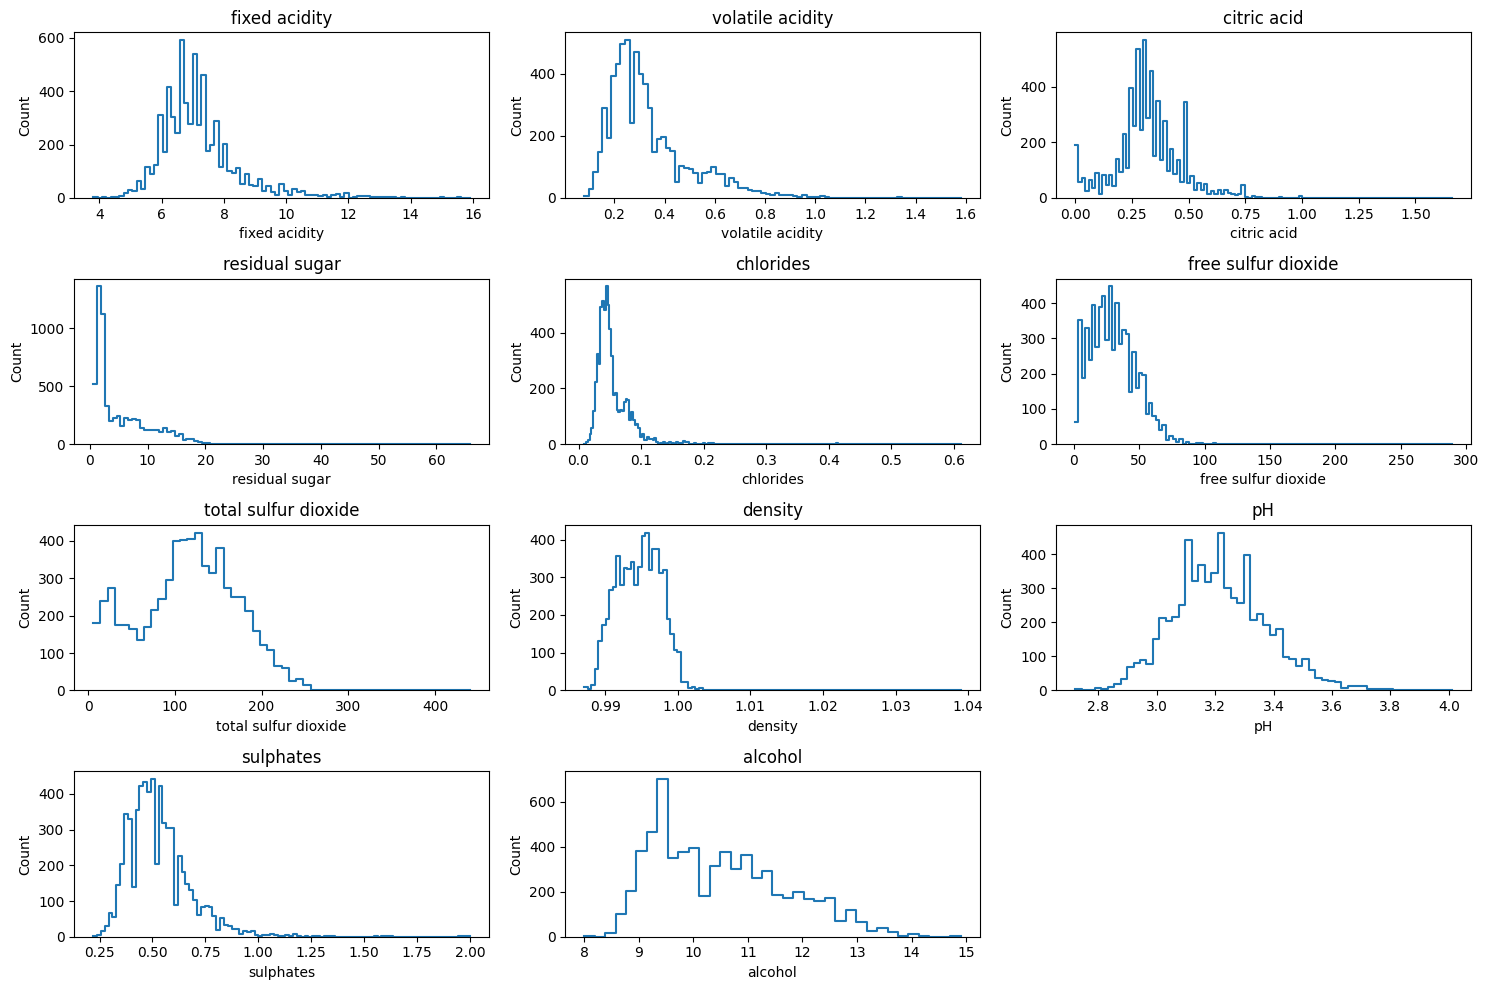

In [5]:
plt.figure(figsize = (15, 10))
for x, col in enumerate(data.columns, 1):
    plt.subplot(4, 3, x)
    sns.histplot(data[col], element = 'step', fill = False)
    plt.title(col)
    
plt.tight_layout()
plt.show()

We can see from the histograms above that certain features like to have particular values for all wines, such as residual sugar and chlorides, while others are a lot more spread out. This shows the general ranges of values for each feature that classifies a drink as wine.

Below we can see what features tend to have a correlation with one another when it comes to determining similar wines.

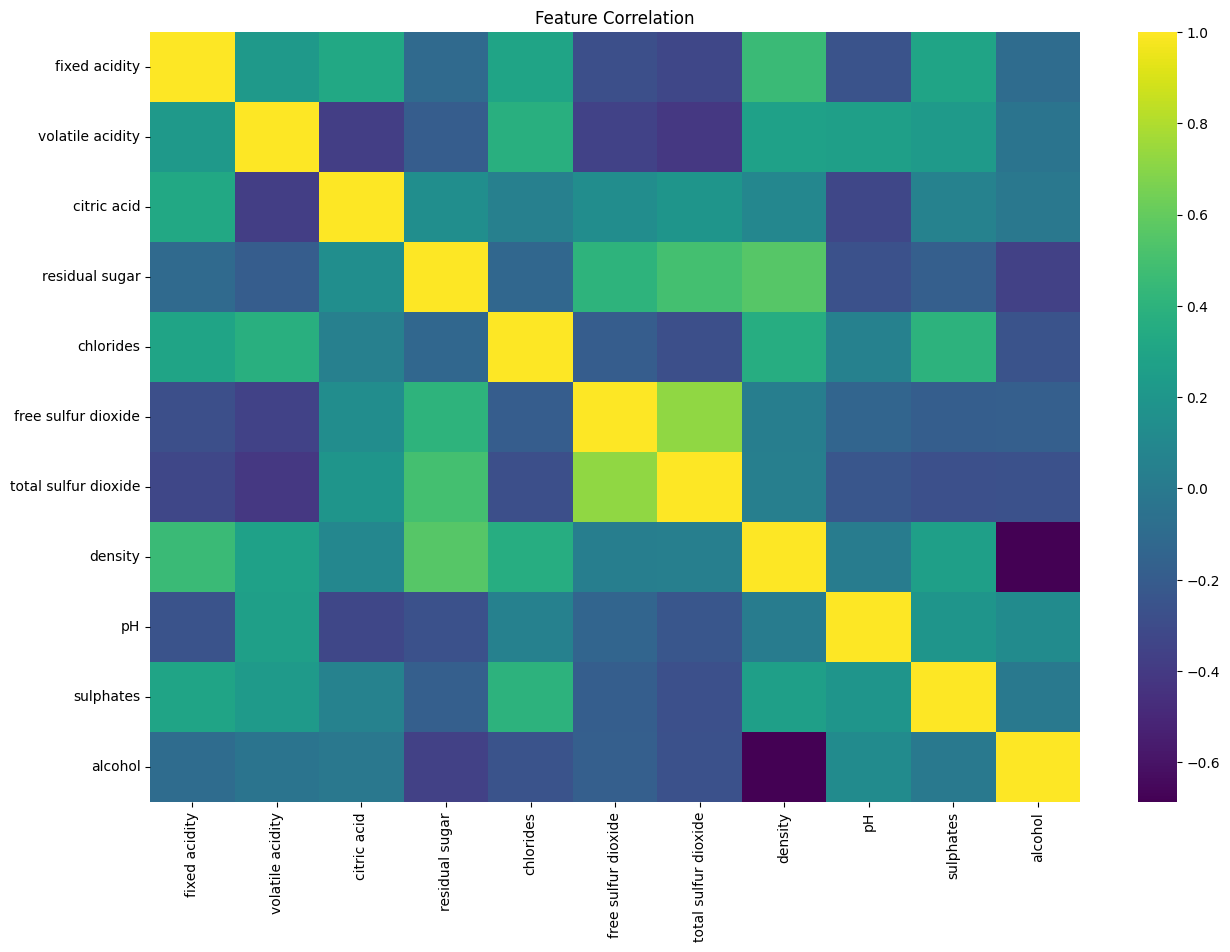

In [6]:
plt.figure(figsize = (15, 10))
sns.heatmap(data.corr(), cmap = 'viridis')
plt.title('Feature Correlation')
plt.show()

In [7]:
print('Top 5 Features:\n''', data.corr().head(5))

Top 5 Features:
                   fixed acidity  volatile acidity  citric acid  \
fixed acidity          1.000000          0.219008     0.324436   
volatile acidity       0.219008          1.000000    -0.377981   
citric acid            0.324436         -0.377981     1.000000   
residual sugar        -0.111981         -0.196011     0.142451   
chlorides              0.298195          0.377124     0.038998   

                  residual sugar  chlorides  free sulfur dioxide  \
fixed acidity          -0.111981   0.298195            -0.282735   
volatile acidity       -0.196011   0.377124            -0.352557   
citric acid             0.142451   0.038998             0.133126   
residual sugar          1.000000  -0.128940             0.402871   
chlorides              -0.128940   1.000000            -0.195045   

                  total sulfur dioxide   density        pH  sulphates  \
fixed acidity                -0.329054  0.458910 -0.252700   0.299568   
volatile acidity             -0

### Step 3: Clustering

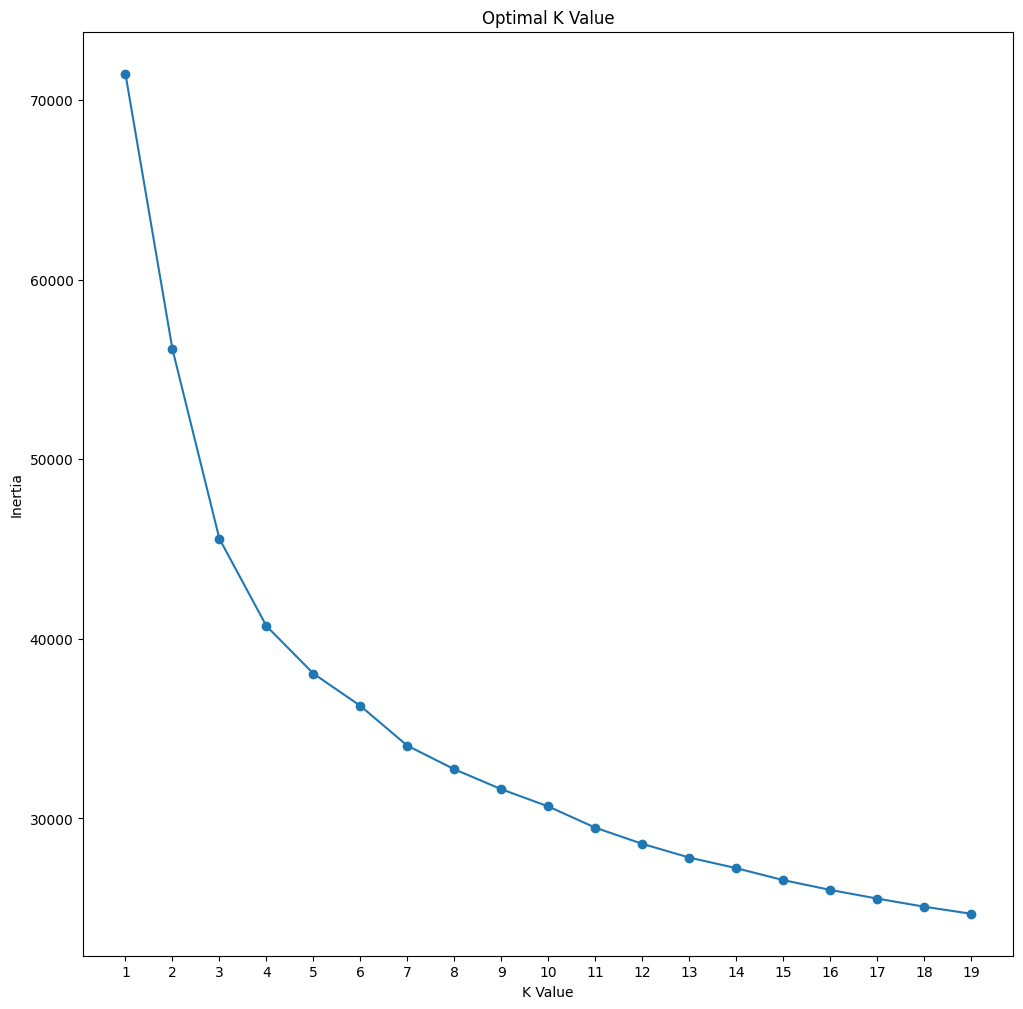

In [8]:
data_scaled = StandardScaler().fit_transform(data)

inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize = (12, 12))
plt.plot(range(1, 20), inertia, marker = 'o')
plt.xticks(range(1,20), range(1,20))
plt.title('Optimal K Value')
plt.xlabel('K Value')
plt.ylabel('Inertia')
plt.show()

By using the Elbow Method, we are able to determine that the best value of n_clusters is 4. We can also confirm this by running the rest of the notebook with different values of n_clusters, which leads to messier results.

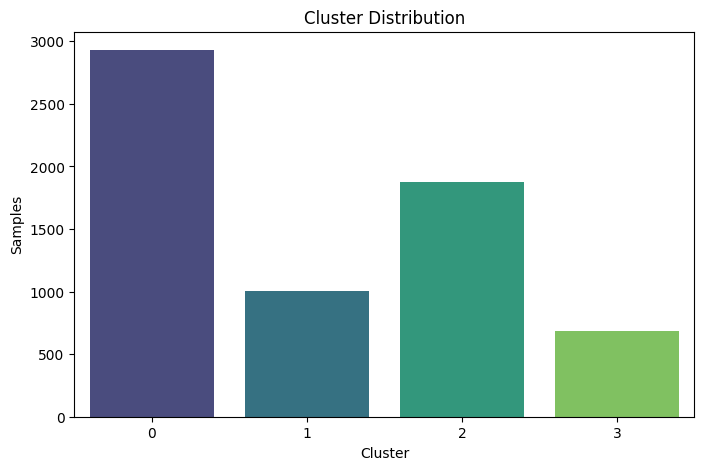

In [9]:
kmeans = KMeans(n_clusters = 4, random_state = 42)
clusters = kmeans.fit_predict(data_scaled)

data['Cluster'] = clusters

plt.figure(figsize = (8, 5))
sns.countplot(data = data, x = 'Cluster', palette = 'viridis')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Samples')
plt.show()

Looking at the count of each of the four clusters, we can assume that cluster 0 and 2 will have the tightest grouping, as they have the most samples in their respective clusters. Cluster 3 will have the worst out of the bunch since its sample size is the lowest. 

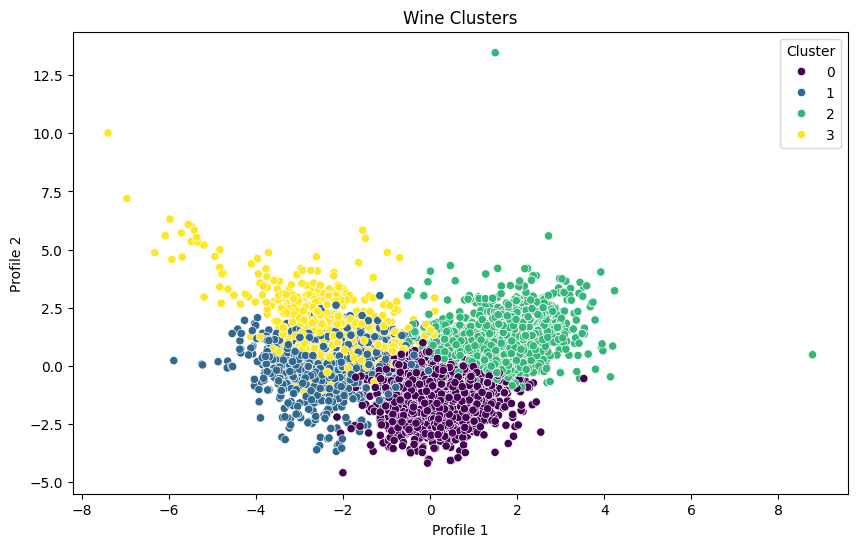

In [10]:
pca = PCA(n_components = 2).fit_transform(data_scaled)
data['PCA1'] = pca[:, 0]
data['PCA2'] = pca[:, 1]

plt.figure(figsize = (10, 6))
sns.scatterplot(x = 'PCA1', y = 'PCA2', hue = 'Cluster', data = data, palette = 'viridis')
plt.title('Wine Clusters')
plt.xlabel('Profile 1')
plt.ylabel('Profile 2')
plt.show()

As we predicted above, cluster 0 has the tightest cluster out of the four since it has the highest number of values, whereas cluster 3 is the most spread out due to its low size. What's interesting is the amount of mixing between clusters three and one. This could be due to both clusters not having as high of a sample size as the other two clusters, and this could lead to bad wine recommendations. It's also worth noting that although cluster 2 has the second highest sample size, it has some outliers that are way out from the main cluster. 

### Step 4: Analysis

In [11]:
print(data.groupby('Cluster').mean())

         fixed acidity  volatile acidity  citric acid  residual sugar  \
Cluster                                                                 
0             6.776980          0.267213     0.322802        3.379778   
1             7.255511          0.607433     0.137358        2.507051   
2             6.962947          0.280916     0.357624       11.230860   
3             9.713828          0.416354     0.460262        2.768486   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
Cluster                                                                   
0         0.040337            29.192833            118.468259  0.992117   
1         0.078240            16.840616             53.433962  0.996049   
2         0.052392            45.700747            170.083022  0.996986   
3         0.100358            14.893741             47.317322  0.997474   

               pH  sulphates    alcohol      PCA1      PCA2  
Cluster                                         

We can now see the average values of each feature for each of the four clusters. Clusters 0 and 2 tend to have the most unique averages for certain features, while clusters 1 and 3 tend to be pretty similar to one another.

*** 
### Summary

By using K-Means, we are able to define four unique clusters of wines based on the different features provided in the dataset (fixed acidity, volatile acidity, etc). We're able to visualize these groups on a scatterplot, and determine the mean value of each feature for each of the different clusters. Wines within each cluster share similar feature profiles, which can be used to show customers new wines that are similar to their taste and preferences. 

To improve the notebook in the future, we can separate red and white wines for more accurate clustering, as red and white wines are produced in similar, but different fashions. An additional segment can be added that would allow a user to input a wine found in the dataset and get several recommendations based on their input. The dataset does not name the wines used, so a different dataset would have to be used that includes wine names. 